In [21]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [22]:
# Mount Google drive which has classification images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Unzip Images
!unzip drive/"My Drive"/Image_Classification.zip

Archive:  drive/My Drive/Image_Classification.zip
replace Image_Classification/paper/04l5I8TqdzF9WDMJ.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Image_Classification/paper/0a3UtNzl5Ll3sq8K.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Image_Classification/paper/0a3UtNzl5Ll3sq8K.png  
  inflating: Image_Classification/paper/0cb6cVL8pkfi4wF6.png  
  inflating: Image_Classification/paper/0eqArS2GgsBeqgSn.png  
  inflating: Image_Classification/paper/0Og76sl5CJhbxWWx.png  
  inflating: Image_Classification/paper/0RA9rcrv8iVvuDDU.png  
  inflating: Image_Classification/paper/0t08v9bAaA0mXGCQ.png  
  inflating: Image_Classification/paper/0Uomd0HvOB33m47I.png  
  inflating: Image_Classification/paper/0vugygEjxQJPr9yz.png  
  inflating: Image_Classification/paper/0zKU6wEhT2cDe9j0.png  
  inflating: Image_Classification/paper/14K62H4KG1hg5qiJ.png  
  inflating: Image_Classification/paper/1Dfw5FRlS4h60JPX.png  
  inflating: Image_Classification/paper/1fKclJk4eBWOQSR1.png  


In [24]:
# Data directory is Image_Classification which has 3 subfolders rock,paper,scissor with 100 images each
print(len(os.listdir('Image_Classification/rock')))
print(len(os.listdir('Image_Classification/paper')))
print(len(os.listdir('Image_Classification/scissor')))


100
100
100


In [25]:
# Images are of different dimensions.Hence preprocessing images to same dimensions
batch_size = 32
img_height = 180
img_width = 180

In [26]:
data_dir = 'Image_Classification'

In [27]:
# Dividing 80% to train and 20% to test dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 240 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [29]:
# Labels of training images
class_names = train_ds.class_names
print(class_names)

['paper', 'rock', 'scissor']


tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


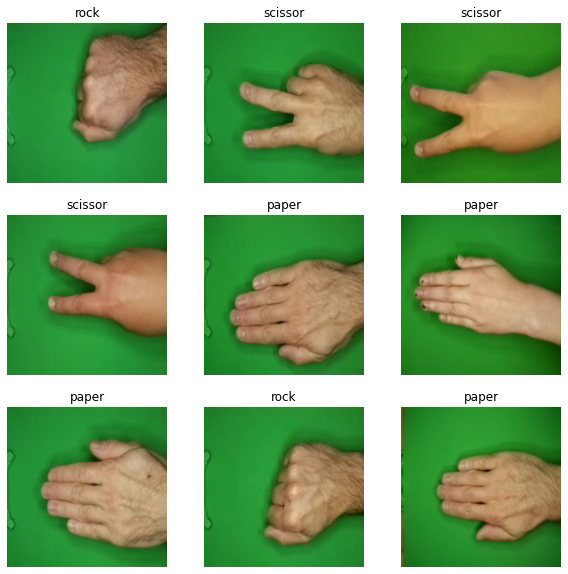

In [30]:
# Plotting images after preprocessing to same dimensions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(labels[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [31]:

# Using cache() to improve memory efficiency
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
# Normalizing images 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [33]:
# As number of images are less, using Horizontal and Vertical flip, rotation, zoom on images 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [34]:
# Adding Conv2D, MaxPooling, Drop out layers to Sequential model
num_classes = 3

model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 16)       

In [37]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 21s 2s/step - loss: 1.0973 - accuracy: 0.3583 - val_loss: 1.0941 - val_accuracy: 0.3833
Epoch 2/20
8/8 [==============================] - 17s 2s/step - loss: 1.0913 - accuracy: 0.4000 - val_loss: 1.0534 - val_accuracy: 0.4500
Epoch 3/20
8/8 [==============================] - 17s 2s/step - loss: 1.0587 - accuracy: 0.4458 - val_loss: 1.0333 - val_accuracy: 0.4833
Epoch 4/20
8/8 [==============================] - 17s 2s/step - loss: 1.0297 - accuracy: 0.4750 - val_loss: 0.9194 - val_accuracy: 0.7333
Epoch 5/20
8/8 [==============================] - 17s 2s/step - loss: 0.9614 - accuracy: 0.5500 - val_loss: 0.8633 - val_accuracy: 0.6333
Epoch 6/20
8/8 [==============================] - 17s 2s/step - loss: 0.9128 - accuracy: 0.5792 - val_loss: 0.8309 - val_accuracy: 0.8000
Epoch 7/20
8/8 [==============================] - 17s 2s/step - loss: 0.8357 - accuracy: 0.6500 - val_loss: 0.7378 - val_accuracy: 0.6833
Epoch 8/20
8/8 [==================

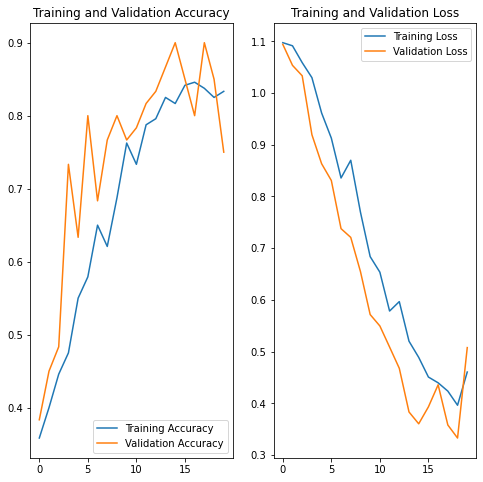

In [38]:
# Visualizing Training and Validation losses
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
# Observation - Accuracy on test dataset is 75%
model.evaluate(val_ds)

2/2 [==============================] - 1s 430ms/step - loss: 0.5079 - accuracy: 0.7500


[0.5078924894332886, 0.75]

In [40]:
predictions = model.predict(val_ds)
predicted_labels = predictions.argmax(axis=-1)
predicted_labels

array([0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 2,
       0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 0, 2, 2, 1, 0, 2, 2, 1,
       0, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1])

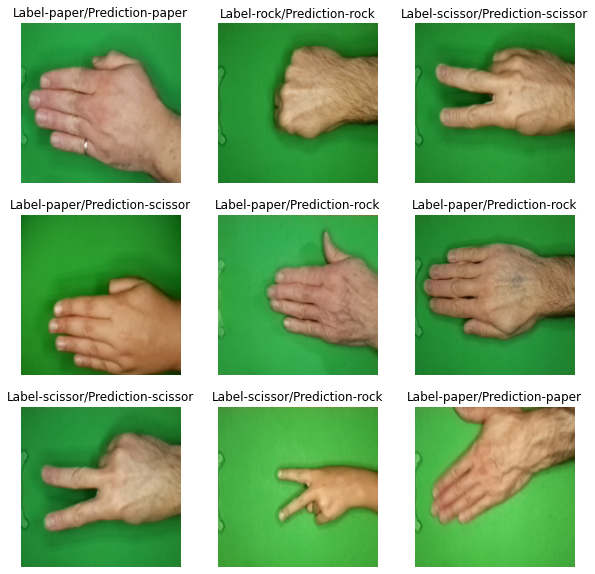

In [42]:
# Visualization of actual labels and predicted labels 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Label-{class_names[labels[i]]}/Prediction-{class_names[predicted_labels[i]]}')
    plt.axis("off")